# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

1.8.0+cu101


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

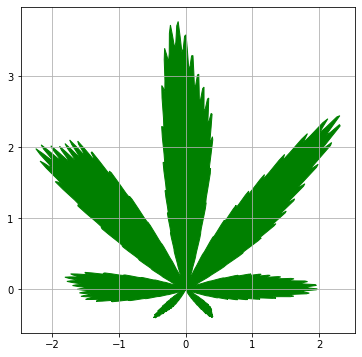

In [2]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(23 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [3]:
from scipy.signal import correlate2d as conv2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = conv2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [4]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    conv = torch.FloatTensor(np.array([[1,1,1],
                                    [1,0,1],
                                    [1,1,1]]))
    
    N = F.conv2d(Z.view(1, 1, Z.shape[0], Z.shape[1]),
                 conv.view(1, 1, 3, 3), padding=1)
    
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
        
    return Z


In [5]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


In [6]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('notmnist.py','wb').write(src)

Saving notmnist.py to notmnist.py


1805

In [8]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters='ABCDEFGHIJ'))
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


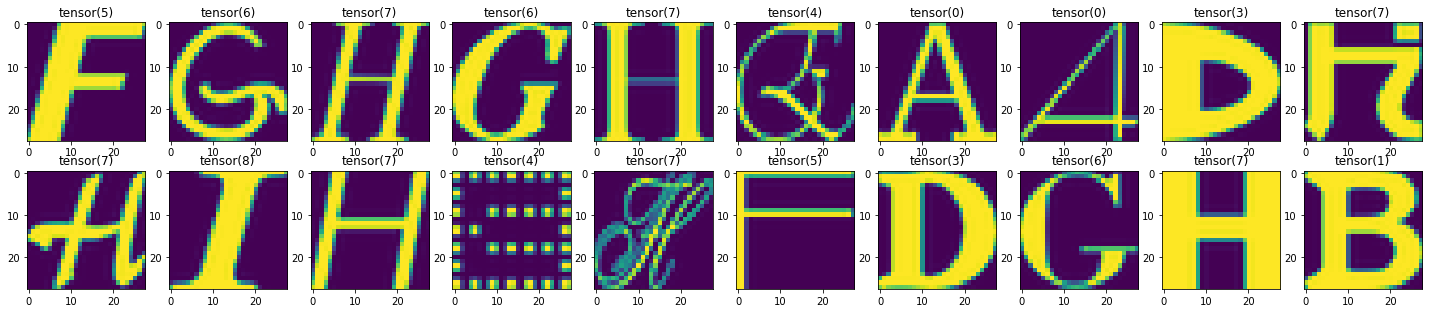

In [9]:
%matplotlib inline
plt.figure(figsize=[25,5])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [10]:
class NeuralNetwork:
    def __init__(self, learning_rate=0.05):
        self.learning_rate = learning_rate

        self.w1 = torch.zeros(28*28, 256, requires_grad=True)
        self.w1.data.normal_(0, 0.01)

        self.b1 = torch.zeros(256, requires_grad=True)
        self.b1.data.normal_(0, 0.01)

        self.w2 = torch.zeros(256, 10, requires_grad=True)
        self.w2.data.normal_(0, 0.01)

        self.b2 = torch.zeros(10, requires_grad=True)
        self.w2.data.normal_(0, 0.01)

    def predict(self, X):
        layer1 = torch.add(torch.matmul(X, self.w1), self.b1)
        activation1 = torch.max(layer1, torch.zeros(layer1.size()))

        layer2 = torch.add(torch.matmul(activation1, self.w2), self.b2)
        activation2 = torch.softmax(layer2, dim=1)
        return activation2

    def grad_step(self):
        self.w1.data -= self.learning_rate * self.w1.grad.data
        self.b1.data -= self.learning_rate * self.b1.grad.data

        self.w2.data -= self.learning_rate * self.w2.grad.data
        self.b2.data -= self.learning_rate * self.b2.grad.data
    
    def set_zero_grad(self):
        self.w1.grad = torch.zeros_like(self.w1)
        self.b1.grad = torch.zeros_like(self.b1)

        self.w2.grad = torch.zeros_like(self.w2)
        self.b2.grad = torch.zeros_like(self.b2)
        return self
  
    def get_loss(self, predict, target):
        return -torch.sum(target * torch.log(predict)) / target.size(0)

In [11]:
def get_one_hot(target):
    one_hot = torch.zeros(target.shape[0], 10)
    one_hot[torch.arange(len(target)), target] = 1
    return one_hot

In [12]:
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = torch.randperm(n_samples)
    batches_idx = torch.split(indices, batch_size)
    for batch_idx in batches_idx:
        yield X[batch_idx], y[batch_idx]

In [13]:
def accuracy(predict, target):
    predict_target = torch.argmax(predict, dim=1)
    return float(torch.sum(torch.eq(predict_target, target))) / target.size(0)

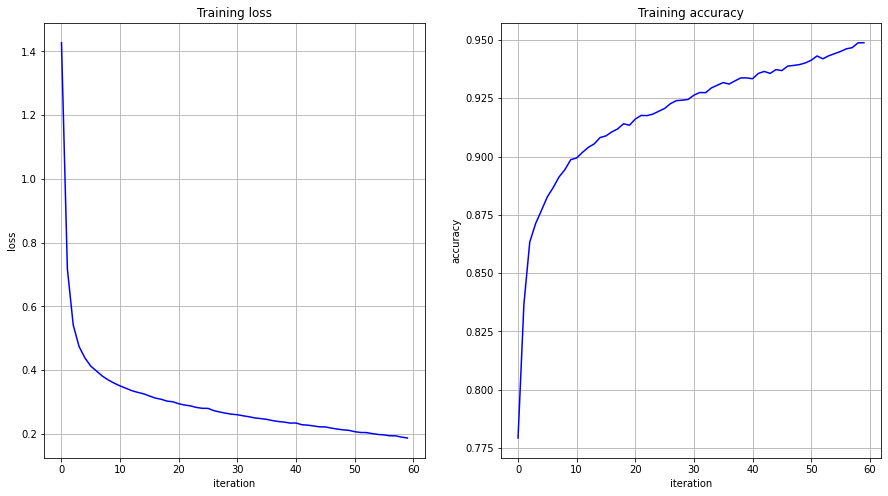

In [14]:
from IPython import display
neural_network = NeuralNetwork()

n_epoch = 60
batch_size = 500

training_loss = []
training_accuracy = []
test_accuracy = []
for i in range(n_epoch):
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        y_batch_one_hot = get_one_hot(y_batch)

        neural_network.set_zero_grad()
        predict = neural_network.predict(X_batch)

        loss = neural_network.get_loss(predict, y_batch_one_hot)

        loss.backward()
        neural_network.grad_step()

    predict = neural_network.predict(X_train)

    acc = accuracy(predict, y_train)
    training_accuracy.append(acc)

    loss = neural_network.get_loss(predict, get_one_hot(y_train))
    training_loss.append(loss)

    display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    ax[0].set_title("Training loss")
    ax[0].set_xlabel("iteration")
    ax[0].set_ylabel("loss")
    ax[0].plot(training_loss, 'b')
    ax[0].grid()

    ax[1].set_title("Training accuracy")
    ax[1].set_xlabel("iteration")
    ax[1].set_ylabel("accuracy")
    ax[1].plot(training_accuracy, 'b')
    ax[1].grid()

    plt.show()

In [15]:
print("accuracy on train = ", accuracy(neural_network.predict(X_train), y_train))
print("accuracy on test = ", accuracy(neural_network.predict(X_test), y_test))

accuracy on train =  0.9488001139357687
accuracy on test =  0.9064302499465926


```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

